# March 2022  - Time Series Data

## 1. Import Libraries and Data
## 2. Explore Data
## 3. Subsetting, wrangling, and cleaning data
## 4. Time-series analysis: decomposition
## 5. Testing for stationarity
## 6. Stationarizing the Data

### 1. Import Libraries and Data

In [1]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm  
# statistical models.
import os
import warnings

warnings.filterwarnings("ignore") # Disable deprecation warnings

plt.style.use('fivethirtyeight') # Styling Option

In [2]:
# Configure API key 

quandl.ApiConfig.api_key = 'mkRenD-KdwfxoMrroDBr'

In [3]:
# Importing the Federal Reserve Economic Data "Real Mean Personal Income in the United States" variable.

data = quandl.get('FRED/MAPAINUSA672N')

### 2. Explore data

In [4]:
data.head(5)

,Value
Date,
1974-01-01,34441.0
1975-01-01,33795.0
1976-01-01,34188.0
1977-01-01,34671.0
1978-01-01,34509.0


In [14]:
data.tail(5)

,Value
Date,
2016-01-01,50212.0
2017-01-01,51727.0
2018-01-01,51967.0
2019-01-01,54804.0
2020-01-01,53996.0


In [5]:
data.shape

(47, 1)

In [6]:
data.columns

Index(['Value'], dtype='object')

In [7]:
type(data)

pandas.core.frame.DataFrame

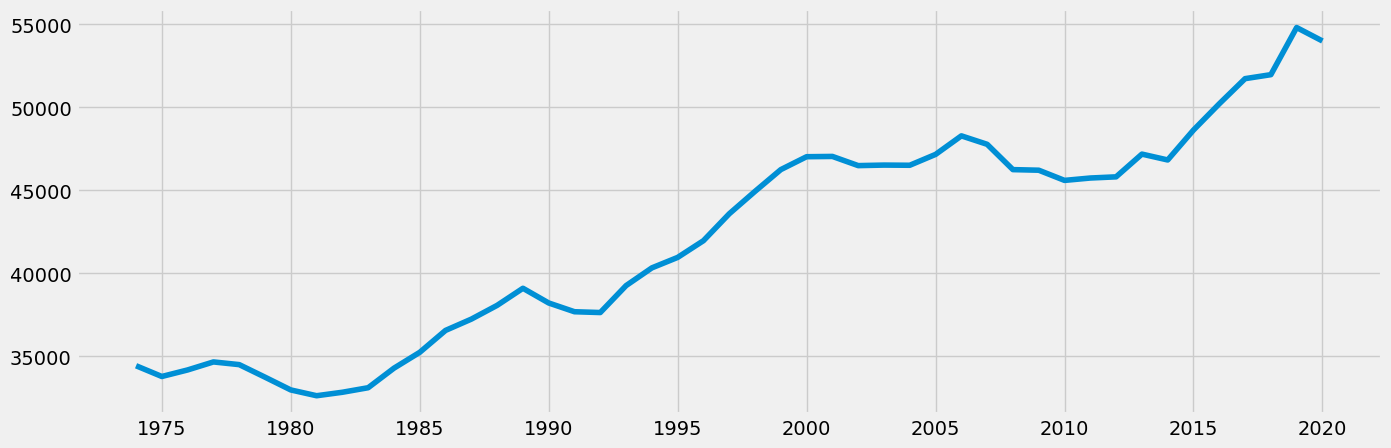

In [8]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100)

plt.plot(data)

### 3. Subsetting, wrangling, and cleaning data

In [17]:
# Reset index to subset to 30 years of data

data_2 = data.reset_index()

### I chose to subset the most recent 30 years of data from this as income is so various from year to year.  Incomes from 50-60 years ago are drastically different than now.  Even though 30 years is still a large range, it brings everything more recent.

In [18]:
data_2.head()

,Date,Value
0,1974-01-01,34441.0
1,1975-01-01,33795.0
2,1976-01-01,34188.0
3,1977-01-01,34671.0
4,1978-01-01,34509.0


In [19]:
data_sub = data_2.loc[(data_2['Date'] >= '1990-01-01') & (data_2['Date'] < '2020-01-01')]

In [20]:
data_sub.shape

(30, 2)

In [21]:
data_sub.head()

,Date,Value
16,1990-01-01,38220.0
17,1991-01-01,37693.0
18,1992-01-01,37645.0
19,1993-01-01,39268.0
20,1994-01-01,40334.0


In [22]:
# Set the "Date" column as the index for time series analysis

from datetime import datetime

data_sub['datetime'] = pd.to_datetime(data_sub['Date']) 
data_sub = data_sub.set_index('datetime') 
data_sub.drop(['Date'], axis=1, inplace=True)
data_sub.head()

,Value
datetime,
1990-01-01,38220.0
1991-01-01,37693.0
1992-01-01,37645.0
1993-01-01,39268.0
1994-01-01,40334.0


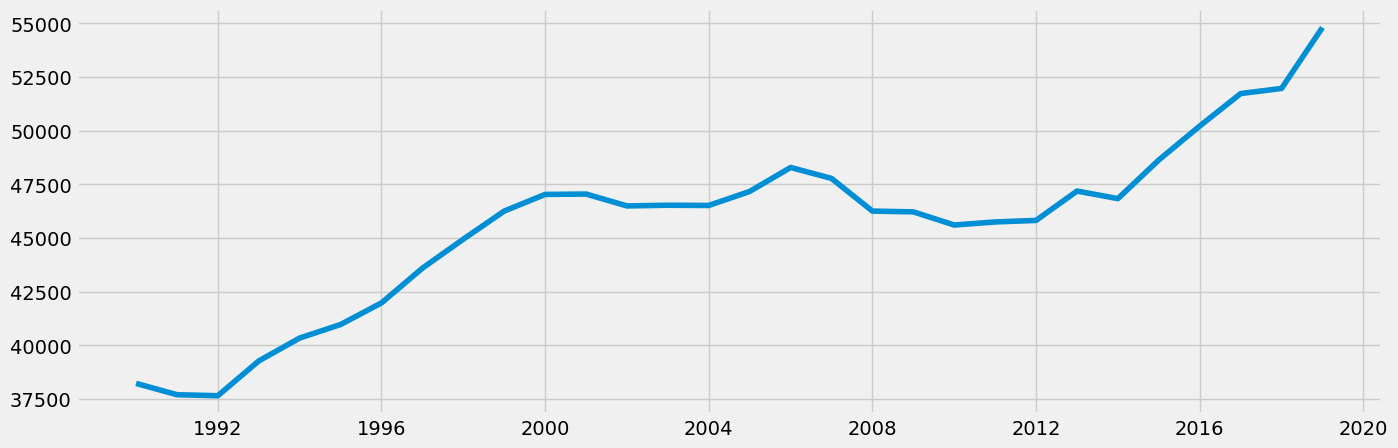

In [23]:
# Plot subset data

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

In [24]:
# Check for missing values

data_sub.isnull().sum() 

Value    0
dtype: int64

In [25]:
# Check for duplicates

dups = data_sub.duplicated()
dups.sum()

# No dups!

0

### 4. Time-series analysis: decomposition

In [26]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(data_sub, model='additive')

In [27]:
from pylab import rcParams # Define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

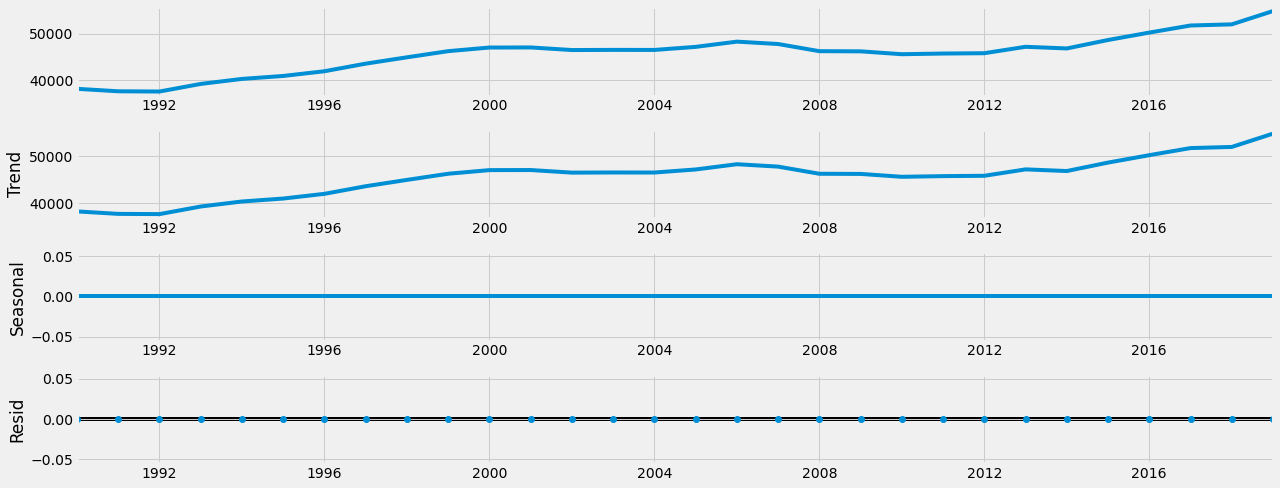

In [28]:
# Plot the separate components

decomposition.plot()
plt.show()

## Decomposition Review

### The top line is our actual  data
### The second line is our trend, as we can see it looks like our data is trending up (therefore won't be stationary but we will test statistically to be sure)
### Our 3rd line is seasonality.  Our curve is flat so we do not have seasonality (as this is yearly data we wouldn't have seasonal information)
### Our last line is our Residual data.  We want this line to be a close to flat as possible and it looks flat which is great because that means there is no extra noise in the data

### 5. Testing for stationarity

In [29]:
# Use adfuller() function to return an array of numbers. 
# define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller 

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_sub['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                  0.695971
p-value                         0.989757
Number of Lags Used             8.000000
Number of Observations Used    21.000000
Critical Value (1%)            -3.788386
Critical Value (5%)            -3.013098
Critical Value (10%)           -2.646397
dtype: float64


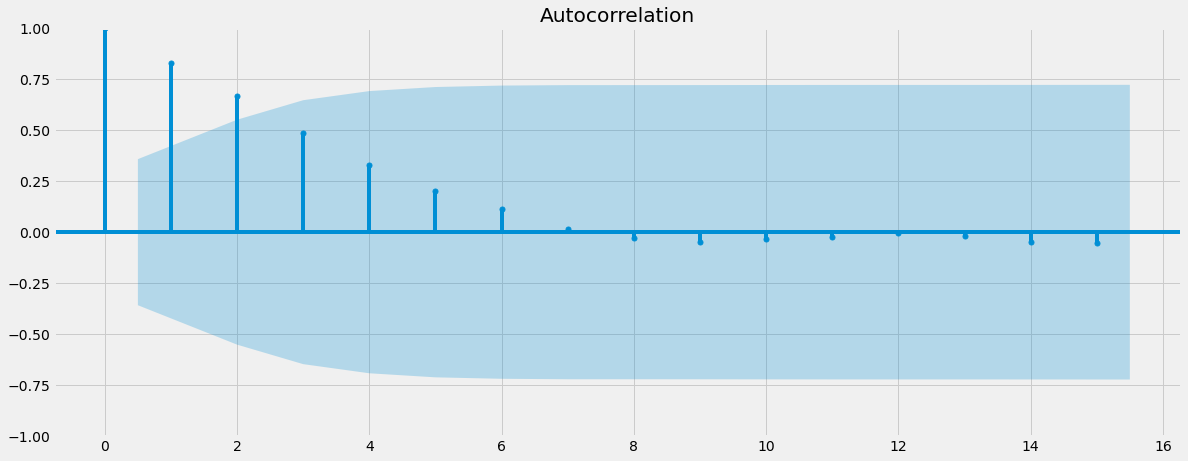

In [30]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data_sub)
plt.show()

## Stationarity Review

### Our null hypothesis is is the presence of a unit root - we want to disprove this to show our data is stationary.
### To test our hypothesis we first used the Dickey-Fuller test, in this we want our test statistic to be smaller than the critical value - we'll use 5%
### Critical Value (5%) is -3.01 < Test Statistic .695
### As the test statistic is higher, we cannot reject our null hypothesis and need to work on making the data stationary

### Our other check was for autocorrelation, we are looking for lines that are above the blue area which is the confidence interval.  As we only have 3 lines above, the autocorrelation is fine, but we still need to adjust data to be more stationary due to the Dickey-Fuller Test

### 6. Stationarizing the Data

In [32]:
data_diff = data_sub - data_sub.shift(1) #shift data

In [33]:
data_diff.dropna(inplace = True) #drop any missing values that came from the shift

In [34]:
data_diff.head()

,Value
datetime,
1991-01-01,-527.0
1992-01-01,-48.0
1993-01-01,1623.0
1994-01-01,1066.0
1995-01-01,630.0


In [35]:
data_diff.columns

Index(['Value'], dtype='object')

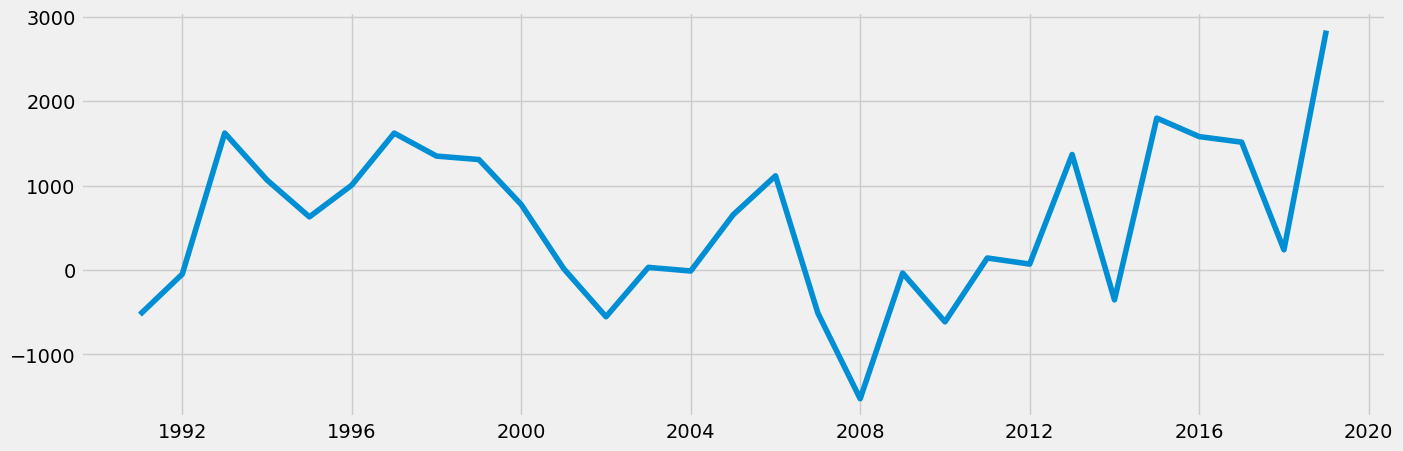

In [36]:
# Plot new data

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [37]:
dickey_fuller(data_diff) #re-run dickey-fuller test

Dickey-Fuller Stationarity test:
Test Statistic                 -2.172755
p-value                         0.216282
Number of Lags Used             7.000000
Number of Observations Used    21.000000
Critical Value (1%)            -3.788386
Critical Value (5%)            -3.013098
Critical Value (10%)           -2.646397
dtype: float64


### We used differencing to shift the data using t - (t-1). As we can see the test statistic is -2.17 which is still larger than the critical value of -3.01 (even though the graph looks more stationary).  
### To resolve this we will re-run the differencing technique

In [38]:
data_diff2 = data_diff - data_diff.shift(1) #shift data

In [39]:
data_diff2.dropna(inplace = True) #drop any missing values that came from the shift

In [40]:
data_diff2.head()

,Value
datetime,
1992-01-01,479.0
1993-01-01,1671.0
1994-01-01,-557.0
1995-01-01,-436.0
1996-01-01,376.0


In [41]:
data_diff2.columns

Index(['Value'], dtype='object')

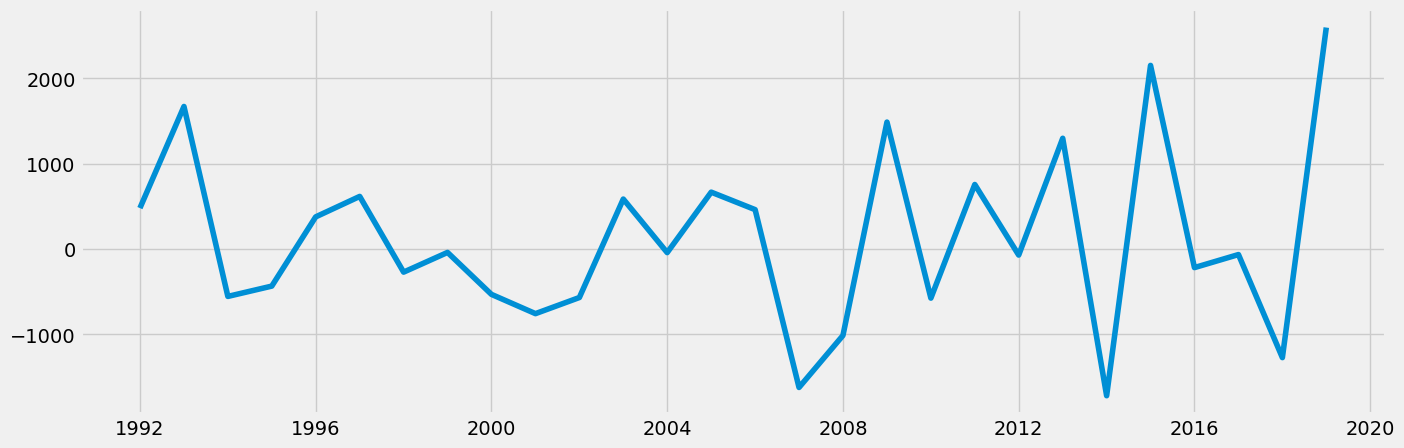

In [42]:
# Plot new data

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff2)

In [43]:
dickey_fuller(data_diff2) #re-run dickey-fuller test

Dickey-Fuller Stationarity test:
Test Statistic                 -1.836135
p-value                         0.362675
Number of Lags Used             5.000000
Number of Observations Used    22.000000
Critical Value (1%)            -3.769733
Critical Value (5%)            -3.005426
Critical Value (10%)           -2.642501
dtype: float64


### After running this a second time our Test Statistic of - 1.83 is still larger than the critical value of -3.00 so we will run it one more time.

In [44]:
data_diff3 = data_diff2 - data_diff2.shift(1) #shift data

In [45]:
data_diff3.dropna(inplace = True) #drop any missing values that came from the shift

In [46]:
data_diff3.head()

,Value
datetime,
1993-01-01,1192.0
1994-01-01,-2228.0
1995-01-01,121.0
1996-01-01,812.0
1997-01-01,240.0


In [47]:
data_diff3.columns

Index(['Value'], dtype='object')

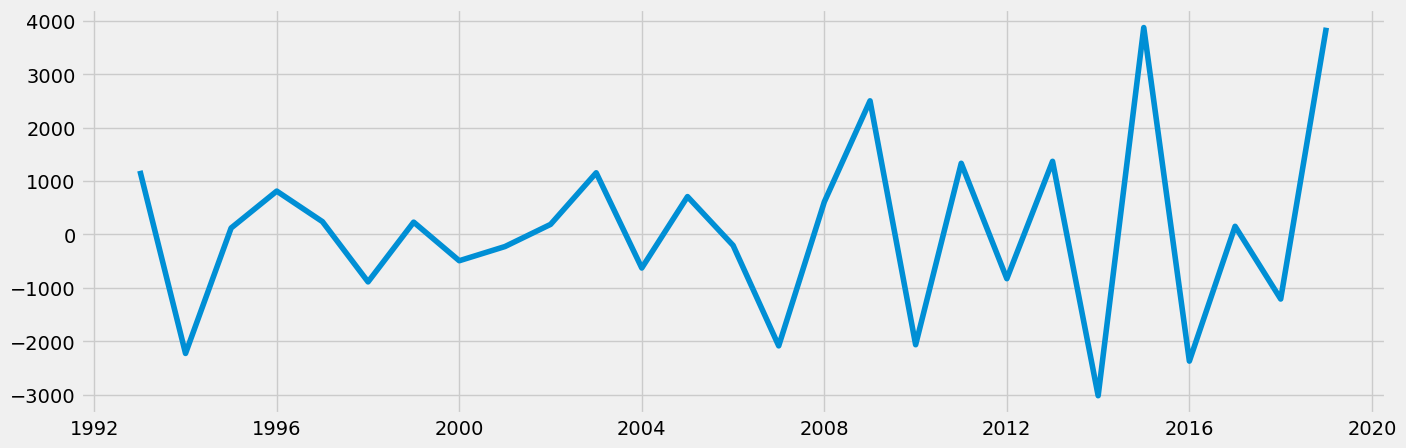

In [48]:
# Plot new data

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff3)

In [49]:
dickey_fuller(data_diff3) #re-run dickey-fuller test

Dickey-Fuller Stationarity test:
Test Statistic                 -3.513347
p-value                         0.007651
Number of Lags Used             5.000000
Number of Observations Used    21.000000
Critical Value (1%)            -3.788386
Critical Value (5%)            -3.013098
Critical Value (10%)           -2.646397
dtype: float64


### This final time our test statistic is -3.52 which is smaller than the critical value of -3.01.  This means we can reject our null hypothosis and our data is now considered stationary.  I will again run the autocorrelation test on the new data as well.

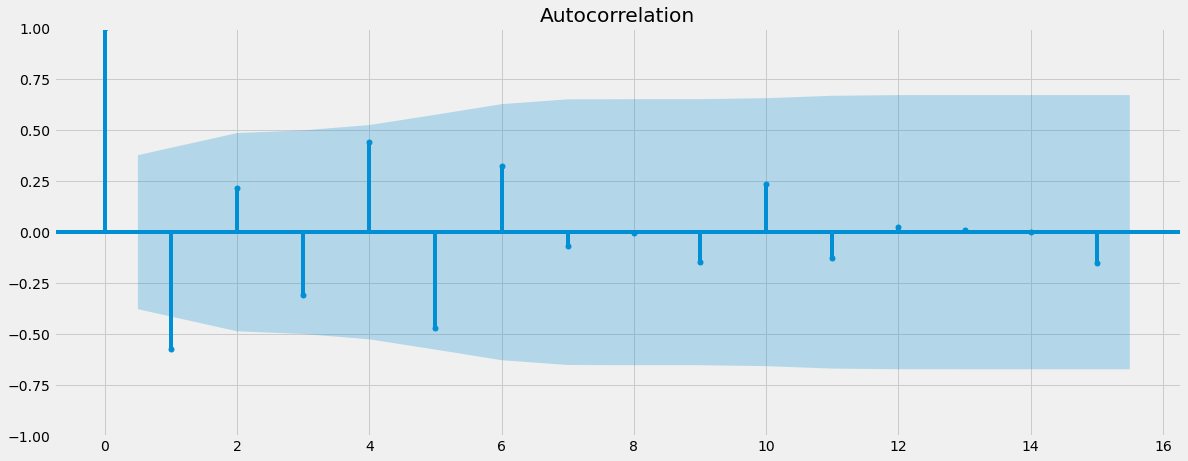

In [50]:
# Check out a plot of autocorrelations

plot_acf(data_diff3)
plt.show()

### As we only have 2 lines that are outside of the confidence interval we can say the data is stationary and move on with a forecast if desired.